In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Загрузка данных
train_df = pd.read_csv("dataset/train.csv", encoding="latin1")
test_df = pd.read_csv("dataset/test.csv", encoding="latin1")
test_salaries_df = pd.read_csv("dataset/test_salaries.csv", encoding="latin1")

In [2]:
# Обработка пропусков
train_df["Pr/St"] = train_df["Pr/St"].fillna(train_df["Pr/St"].mode()[0])
test_df["Pr/St"] = test_df["Pr/St"].fillna(test_df["Pr/St"].mode()[0])

# Удаление строк, где DftYr, DftRd, Ovrl пустые
train_df = train_df.dropna(subset=["DftYr", "DftRd", "Ovrl"], how="all")
test_df = test_df.dropna(subset=["DftYr", "DftRd", "Ovrl"], how="all")
test_salaries_df = test_salaries_df.loc[test_df.index]

# Заполнение пропусков в числовых колонках средним значением
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.drop("Salary", errors="ignore")

# Заполняем пропуски средним только в числовых столбцах
train_df[numeric_cols] = train_df[numeric_cols].fillna(train_df[numeric_cols].mean())
test_numeric_cols = numeric_cols.intersection(test_df.columns)  # Числовые столбцы в test_df
test_df[test_numeric_cols] = test_df[test_numeric_cols].fillna(test_df[test_numeric_cols].mean())

In [3]:
# Удаление столбцов с некорректными строковыми значениями (например, датами)
for col in train_df.columns:
    if train_df[col].dtype == "object":
        try:
            train_df[col] = train_df[col].astype(float)
            test_df[col] = test_df[col].astype(float)
        except ValueError:
            train_df = train_df.drop(columns=[col])
            test_df = test_df.drop(columns=[col])

In [4]:
# Разделение признаков и целевой переменной
X_train = train_df.drop(columns=["Salary"])
y_train = train_df["Salary"]
X_test = test_df
y_test = test_salaries_df["Salary"]

# Масштабирование данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# Обучение модели KNN с K=5
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Оценка модели
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"MAE: {mae}")
print(f"MSE: {mse}")

MAE: 1261606.5780590717
MSE: 3783876011847.388


In [6]:
# Подбор гиперпараметров
param_grid = {"n_neighbors": range(1, 30)}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring="neg_mean_absolute_error")
grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_["n_neighbors"]
print(f"Лучшее значение K: {best_k}")

# Обучение модели с лучшим K
knn_best = KNeighborsRegressor(n_neighbors=best_k)
knn_best.fit(X_train, y_train)
y_pred_best = knn_best.predict(X_test)

# Оценка оптимальной модели
mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
print(f"MAE (оптимальная модель): {mae_best}")
print(f"MSE (оптимальная модель): {mse_best}")

Лучшее значение K: 26
MAE (оптимальная модель): 1252415.8972736124
MSE (оптимальная модель): 3660649767832.5654



Сравнение предсказанных и реальных зарплат (первые 10 примеров):
Игрок 1: Предсказано: $3,587,500.00, Реально: $7,000,000.00
Игрок 2: Предсказано: $1,033,365.38, Реально: $925,000.00
Игрок 3: Предсказано: $4,536,538.46, Реально: $2,000,000.00
Игрок 4: Предсказано: $2,579,134.62, Реально: $667,500.00
Игрок 5: Предсказано: $1,013,942.31, Реально: $600,000.00
Игрок 6: Предсказано: $1,142,788.46, Реально: $1,400,000.00
Игрок 7: Предсказано: $1,259,615.38, Реально: $1,600,000.00
Игрок 8: Предсказано: $3,017,307.69, Реально: $7,500,000.00
Игрок 9: Предсказано: $772,403.85, Реально: $4,500,000.00
Игрок 10: Предсказано: $4,370,096.15, Реально: $6,000,000.00
Игрок 11: Предсказано: $1,162,692.31, Реально: $767,500.00
Игрок 12: Предсказано: $1,663,557.69, Реально: $725,000.00
Игрок 13: Предсказано: $4,447,115.38, Реально: $5,750,000.00
Игрок 14: Предсказано: $2,386,730.77, Реально: $4,000,000.00
Игрок 15: Предсказано: $4,253,461.54, Реально: $14,000,000.00
Игрок 16: Предсказано: $3,746,250.00, Р

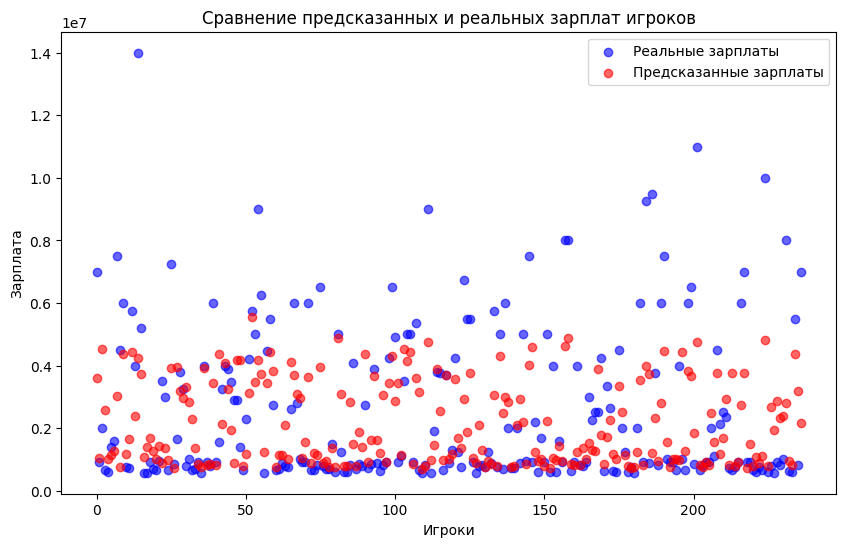

In [7]:
# Вывод предсказанных и реальных значений
print("\nСравнение предсказанных и реальных зарплат (первые 10 примеров):")
for i in range(100):
    print(f"Игрок {i+1}: Предсказано: ${y_pred_best[i]:,.2f}, Реально: ${y_test.iloc[i]:,.2f}")

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label="Реальные зарплаты", color='blue', alpha=0.6)
plt.scatter(range(len(y_pred_best)), y_pred_best, label="Предсказанные зарплаты", color='red', alpha=0.6)
plt.xlabel("Игроки")
plt.ylabel("Зарплата")
plt.legend()
plt.title("Сравнение предсказанных и реальных зарплат игроков")
plt.show()